In [1]:
#load package
using Revise
using Plots
using LaTeXStrings
using LinearAlgebra
using SparseIR
using Nevanlinna

In [2]:
# Set work data Type
T = BigFloat
setprecision(128)
;

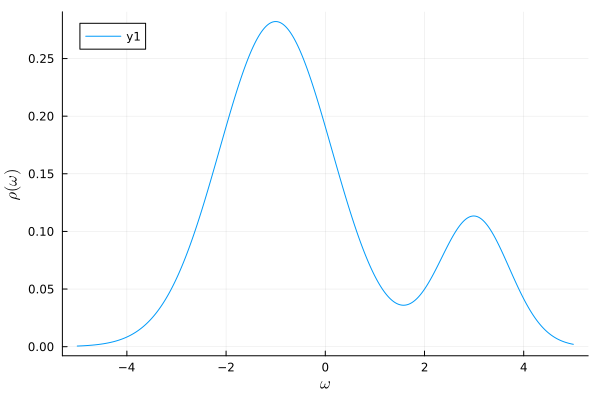

In [3]:
#define spectral function
gaussian(x, mu, sigma) = exp(-((x-mu)/sigma)^2)/(sqrt(π)*sigma)
rho(omega) = 0.8*gaussian(omega, -1.0, 1.6) + 0.2*gaussian(omega, 3, 1)
omegas = LinRange(-5, 5, 1000)
plot()
plot!(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
function generate_input_data(rho::Function, beta::Float64)
    lambda = 1e+4
    wmax = lambda/beta
    basis = FiniteTempBasisSet(beta, wmax, 1e-15)

    rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
    gl = - basis.basis_f.s .* rhol
    gw = evaluate(basis.smpl_wn_f, gl)
    
    hnw = length(basis.smpl_wn_f.sampling_points)÷2
    
    input_smpl = Array{Complex{T}}(undef, hnw) 
    input_gw   = Array{Complex{T}}(undef, hnw) 
    
    for i in 1:hnw
        input_smpl[i]= SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], beta)
        input_gw[i]  = gw[hnw+i]
    end
    
    return input_smpl, input_gw
end

generate_input_data (generic function with 1 method)

In [5]:
beta = 100. #inverse temperature
input_smpl, input_gw = generate_input_data(rho, beta)
;

In [6]:
N_real    = 1000  #demension of array of output
omega_max = 10.0  #energy cutoff of real axis
eta       = 0.001 #broaden parameter 
sum_rule  = 1.0   #sum rule
H_max     = 50    #cutoff of Hardy basis
lambda    = 1e-4  #regularization parameter
iter_tol  = 1000  #upper bound of iteration
;

In [7]:
#construct solver struct
@time sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true)
;

N_imag is setted as 31
H=1
Iter     Function value   Gradient norm 
     0     1.394068e-01     1.354674e+00
 * time: 0.026965856552124023
     1     1.271921e-01     8.719071e-01
 * time: 1.3341619968414307
     2     9.446336e-02     9.728176e-01
 * time: 1.560532808303833
     3     4.352172e-02     1.124699e+00
 * time: 1.8000178337097168
     4     3.614140e-02     6.164562e-02
 * time: 2.027176856994629
     5     3.610852e-02     1.054229e-02
 * time: 2.3360538482666016
     6     3.610750e-02     1.921777e-03
 * time: 2.6791958808898926
     7     3.610748e-02     1.512958e-04
 * time: 2.8768768310546875
     8     3.610748e-02     2.197711e-05
 * time: 3.1913158893585205
     9     3.610748e-02     4.523937e-06
 * time: 3.3871679306030273
    10     3.610748e-02     6.640354e-07
 * time: 3.5792179107666016
    11     3.610748e-02     1.213906e-07
 * time: 3.89384388923645
    12     3.610748e-02     1.825283e-08
 * time: 4.091356992721558
    13     3.610748e-02     3.485925e-

In [8]:
#execute optimize
@time Nevanlinna.solve!(sol)

H=1
Iter     Function value   Gradient norm 
     0     3.610748e-02     3.485925e-09
 * time: 0.0003039836883544922
max_theta=0.07656815618787277843167094722571857204341
hardy optimization was success.
H=2
Iter     Function value   Gradient norm 
     0     3.610748e-02     4.607507e-01
 * time: 0.0002970695495605469
     1     3.458019e-02     3.832203e-01
 * time: 0.23298406600952148
     2     2.842299e-02     3.094581e-01
 * time: 0.612036943435669
     3     2.588584e-02     2.989854e-01
 * time: 0.8309299945831299
     4     1.616310e-02     6.775993e-01
 * time: 1.074779987335205
     5     1.152500e-02     1.850161e-01
 * time: 1.296544075012207
     6     1.100075e-02     6.844742e-02
 * time: 1.6398229598999023
     7     1.081305e-02     3.099662e-02
 * time: 1.9507319927215576
     8     1.079639e-02     1.175092e-02
 * time: 2.304270029067993
     9     1.079535e-02     3.198604e-03
 * time: 2.6681971549987793
    10     1.079526e-02     9.616927e-04
 * time: 2.8888571262

     8     3.541879e-04     1.202338e-02
 * time: 2.598001003265381
     9     3.317255e-04     1.335290e-02
 * time: 3.074826955795288
    10     2.745317e-04     3.095028e-02
 * time: 3.5775179862976074
    11     2.227564e-04     1.468464e-02
 * time: 4.102901935577393
    12     2.109885e-04     1.550989e-02
 * time: 4.65985107421875
    13     1.980827e-04     7.102639e-03
 * time: 5.150377988815308
    14     1.965369e-04     5.610650e-03
 * time: 5.642919063568115
    15     1.949621e-04     7.294491e-03
 * time: 6.193919897079468
    16     1.938476e-04     9.328859e-03
 * time: 6.683815002441406
    17     1.909921e-04     1.423532e-02
 * time: 7.197216987609863
    18     1.885461e-04     9.508340e-03
 * time: 7.796226978302002
    19     1.872132e-04     2.752278e-03
 * time: 8.297852039337158
    20     1.869741e-04     2.491821e-03
 * time: 8.606772899627686
    21     1.868090e-04     2.037686e-03
 * time: 9.07848596572876
    22     1.863064e-04     6.669543e-03
 * time:

    31     3.658214e-05     1.812335e-03
 * time: 17.557893991470337
    32     3.654232e-05     1.097643e-03
 * time: 18.20461106300354
    33     3.653096e-05     2.957180e-04
 * time: 18.57280421257019
    34     3.652719e-05     2.805534e-04
 * time: 19.207184076309204
    35     3.652305e-05     5.900462e-04
 * time: 19.798291206359863
    36     3.651569e-05     8.711236e-04
 * time: 20.647618055343628
    37     3.650492e-05     1.293413e-03
 * time: 21.410243034362793
    38     3.648455e-05     1.906224e-03
 * time: 22.234909057617188
    39     3.645302e-05     2.601490e-03
 * time: 23.11009407043457
    40     3.639626e-05     3.719350e-03
 * time: 23.675060033798218
    41     3.631136e-05     4.815348e-03
 * time: 24.284784078598022
    42     3.615692e-05     6.426831e-03
 * time: 24.896700143814087
    43     3.593308e-05     7.807435e-03
 * time: 25.48481011390686
    44     3.552534e-05     9.436206e-03
 * time: 26.160418033599854
    45     3.493243e-05     9.758930e-

     9     2.049205e-05     9.475907e-04
 * time: 3.985051155090332
    10     2.041267e-05     9.157819e-04
 * time: 4.436523199081421
    11     2.028044e-05     1.894858e-03
 * time: 4.92972207069397
    12     2.014403e-05     3.936039e-04
 * time: 5.351057052612305
    13     2.007649e-05     3.635523e-04
 * time: 5.793580055236816
    14     1.964882e-05     1.439704e-03
 * time: 6.479617118835449
    15     1.943455e-05     9.431024e-04
 * time: 7.133136034011841
    16     1.939733e-05     1.213223e-03
 * time: 7.811175107955933
    17     1.933880e-05     1.621055e-03
 * time: 8.610618114471436
    18     1.930072e-05     1.421333e-03
 * time: 9.026316165924072
    19     1.924451e-05     1.385487e-03
 * time: 9.683634042739868
    20     1.912405e-05     1.414850e-03
 * time: 10.347081184387207
    21     1.893356e-05     1.600937e-03
 * time: 11.00748610496521
    22     1.889515e-05     1.630658e-03
 * time: 11.461148977279663
    23     1.883638e-05     1.723667e-03
 * tim

    36     1.527848e-05     1.197263e-03
 * time: 21.731693029403687
    37     1.524659e-05     6.751943e-04
 * time: 22.47609305381775
    38     1.522920e-05     7.725710e-04
 * time: 23.220496892929077
    39     1.522322e-05     4.196670e-04
 * time: 23.689098834991455
    40     1.521540e-05     7.674339e-04
 * time: 24.42619800567627
    41     1.520692e-05     1.011915e-03
 * time: 25.142242908477783
    42     1.518741e-05     1.503984e-03
 * time: 25.80033802986145
    43     1.517102e-05     1.688040e-03
 * time: 26.525678873062134
    44     1.513837e-05     2.069853e-03
 * time: 27.32088589668274
    45     1.510116e-05     1.883023e-03
 * time: 28.007303953170776
    46     1.503281e-05     1.042922e-03
 * time: 28.750135898590088
    47     1.502340e-05     3.368159e-04
 * time: 29.310385942459106
    48     1.501709e-05     2.350737e-04
 * time: 30.247838020324707
    49     1.501422e-05     4.183694e-04
 * time: 31.0939679145813
    50     1.500889e-05     6.389181e-04

    40     1.397075e-05     3.284476e-04
 * time: 25.691878080368042
    41     1.396859e-05     2.591130e-04
 * time: 26.205748081207275
    42     1.396712e-05     3.592539e-04
 * time: 26.953400135040283
    43     1.396435e-05     5.108087e-04
 * time: 27.729208946228027
    44     1.396175e-05     5.554530e-04
 * time: 28.493448972702026
    45     1.395835e-05     6.025578e-04
 * time: 29.359796047210693
    46     1.395248e-05     5.203944e-04
 * time: 30.146151065826416
    47     1.394115e-05     3.852731e-04
 * time: 30.907719135284424
    48     1.393927e-05     2.418871e-04
 * time: 31.39414405822754
    49     1.393680e-05     3.056264e-04
 * time: 32.1381299495697
    50     1.393469e-05     5.252264e-04
 * time: 32.89684295654297
    51     1.393008e-05     7.112393e-04
 * time: 33.66217803955078
    52     1.392604e-05     8.070898e-04
 * time: 34.12883496284485
    53     1.392016e-05     9.472170e-04
 * time: 34.86738204956055
    54     1.391387e-05     9.870620e-04


    13     1.352956e-05     1.802099e-04
 * time: 7.085215091705322
    14     1.352575e-05     2.803441e-04
 * time: 7.6220691204071045
    15     1.352274e-05     2.564498e-04
 * time: 8.176566123962402
    16     1.351968e-05     1.785797e-04
 * time: 8.73394513130188
    17     1.351629e-05     2.453955e-04
 * time: 9.265925168991089
    18     1.351057e-05     1.904613e-04
 * time: 9.809445142745972
    19     1.350757e-05     3.356233e-04
 * time: 10.617698192596436
    20     1.350570e-05     1.769048e-04
 * time: 11.154523134231567
    21     1.349484e-05     4.125885e-04
 * time: 12.236021041870117
    22     1.349064e-05     4.233663e-04
 * time: 13.051372051239014
    23     1.348636e-05     3.261924e-04
 * time: 13.799232006072998
    24     1.347817e-05     2.822121e-04
 * time: 14.586256980895996
    25     1.347551e-05     1.590766e-04
 * time: 15.383136987686157
    26     1.347198e-05     4.028161e-04
 * time: 16.21567702293396
    27     1.346879e-05     3.316796e-04


   134     1.331477e-05     2.040730e-04
 * time: 87.45465016365051
   135     1.331471e-05     2.229314e-04
 * time: 87.98027014732361
   136     1.331463e-05     2.478274e-04
 * time: 88.47083401679993
   137     1.331454e-05     2.706687e-04
 * time: 89.01774215698242
   138     1.331443e-05     3.003322e-04
 * time: 89.55336499214172
   139     1.331431e-05     3.280445e-04
 * time: 90.09680509567261
   140     1.331415e-05     3.633313e-04
 * time: 90.642333984375
   141     1.331397e-05     3.970275e-04
 * time: 91.2013111114502
   142     1.331373e-05     4.388946e-04
 * time: 91.72738718986511
   143     1.331346e-05     4.799556e-04
 * time: 92.22693920135498
   144     1.331311e-05     5.294287e-04
 * time: 92.77021408081055
   145     1.331270e-05     5.795795e-04
 * time: 93.30333614349365
   146     1.331217e-05     6.376482e-04
 * time: 94.1431770324707
   147     1.331155e-05     6.990167e-04
 * time: 94.69191002845764
   148     1.331073e-05     7.662544e-04
 * time: 95

    75     1.322079e-05     2.343852e-04
 * time: 54.527031898498535
    76     1.322064e-05     2.531968e-04
 * time: 55.08149003982544
    77     1.322044e-05     2.925873e-04
 * time: 56.0043420791626
    78     1.322024e-05     3.152398e-04
 * time: 56.590266942977905
    79     1.321996e-05     3.565849e-04
 * time: 57.47504997253418
    80     1.321968e-05     3.827598e-04
 * time: 58.06114602088928
    81     1.321927e-05     4.224109e-04
 * time: 58.94893002510071
    82     1.321882e-05     4.505786e-04
 * time: 59.80272889137268
    83     1.321806e-05     4.762274e-04
 * time: 60.72855305671692
    84     1.321671e-05     4.650127e-04
 * time: 61.54499387741089
    85     1.321214e-05     3.006020e-04
 * time: 62.64627695083618
    86     1.321133e-05     1.592332e-04
 * time: 63.202224016189575
    87     1.321069e-05     1.085457e-04
 * time: 63.78524303436279
    88     1.321061e-05     6.114041e-05
 * time: 64.36579394340515
    89     1.321053e-05     6.049279e-05
 * ti

   195     1.316435e-05     6.806489e-04
 * time: 131.43727898597717
   196     1.316276e-05     7.263416e-04
 * time: 132.33339595794678
   197     1.315924e-05     6.778591e-04
 * time: 133.221186876297
   198     1.314777e-05     4.269559e-04
 * time: 134.3629949092865
   199     1.314659e-05     1.200556e-04
 * time: 134.90160584449768
   200     1.314609e-05     7.122863e-05
 * time: 135.72178387641907
   201     1.314598e-05     7.348155e-05
 * time: 136.59361791610718
   202     1.314594e-05     2.624686e-05
 * time: 137.2548689842224
   203     1.314593e-05     1.832132e-05
 * time: 138.13044905662537
   204     1.314593e-05     1.100307e-05
 * time: 138.726557970047
   205     1.314592e-05     1.019929e-05
 * time: 139.60518503189087
   206     1.314592e-05     3.977719e-06
 * time: 140.16773295402527
   207     1.314592e-05     4.027910e-06
 * time: 140.99943685531616
   208     1.314592e-05     2.101566e-06
 * time: 141.53289604187012
   209     1.314592e-05     1.760010e-06

    92     1.312776e-05     1.701460e-04
 * time: 69.79541206359863
    93     1.312755e-05     2.305307e-04
 * time: 70.69720506668091
    94     1.312742e-05     2.214947e-04
 * time: 71.2872622013092
    95     1.312708e-05     2.918612e-04
 * time: 72.20692300796509
    96     1.312686e-05     2.778952e-04
 * time: 72.82126903533936
    97     1.312622e-05     2.858309e-04
 * time: 73.74058818817139
    98     1.312507e-05     2.550725e-04
 * time: 74.64624810218811
    99     1.312407e-05     3.066951e-04
 * time: 75.51879715919495
   100     1.312360e-05     1.249160e-04
 * time: 76.1413311958313
   101     1.312344e-05     7.600180e-05
 * time: 76.96282410621643
   102     1.312340e-05     4.467923e-05
 * time: 77.54009699821472
   103     1.312336e-05     4.203932e-05
 * time: 78.39767122268677
   104     1.312335e-05     1.650231e-05
 * time: 78.97687816619873
   105     1.312334e-05     1.824340e-05
 * time: 79.89861512184143
   106     1.312334e-05     9.351868e-06
 * time: 

   212     1.309375e-05     5.597397e-06
 * time: 161.87603116035461
   213     1.309375e-05     2.758212e-06
 * time: 162.58763718605042
   214     1.309375e-05     2.752495e-06
 * time: 163.6347460746765
   215     1.309375e-05     1.170310e-06
 * time: 164.19621014595032
   216     1.309375e-05     1.114928e-06
 * time: 165.19272303581238
   217     1.309375e-05     5.643745e-07
 * time: 165.84783816337585
   218     1.309375e-05     4.971916e-07
 * time: 166.7988681793213
   219     1.309375e-05     2.463509e-07
 * time: 167.4200792312622
   220     1.309375e-05     2.435417e-07
 * time: 168.51808500289917
   221     1.309375e-05     9.971710e-08
 * time: 169.24487709999084
   222     1.309375e-05     1.045631e-07
 * time: 170.3632152080536
   223     1.309375e-05     5.728907e-08
 * time: 171.01228213310242
   224     1.309375e-05     4.315268e-08
 * time: 171.9301290512085
   225     1.309375e-05     2.302902e-08
 * time: 172.53080415725708
   226     1.309375e-05     2.085744e-0

   103     1.308527e-05     2.049975e-05
 * time: 84.87551999092102
   104     1.308527e-05     1.826964e-05
 * time: 85.51819086074829
   105     1.308526e-05     2.813772e-05
 * time: 86.45435500144958
   106     1.308526e-05     2.551748e-05
 * time: 87.12535500526428
   107     1.308525e-05     3.648168e-05
 * time: 88.26986885070801
   108     1.308525e-05     3.359561e-05
 * time: 89.09213900566101
   109     1.308524e-05     4.882841e-05
 * time: 90.21741199493408
   110     1.308524e-05     4.658370e-05
 * time: 90.89775204658508
   111     1.308522e-05     6.163459e-05
 * time: 91.91089701652527
   112     1.308521e-05     5.847268e-05
 * time: 92.56960582733154
   113     1.308519e-05     7.724466e-05
 * time: 93.59401798248291
   114     1.308518e-05     7.447997e-05
 * time: 94.26631498336792
   115     1.308515e-05     9.772820e-05
 * time: 95.35310101509094
   116     1.308513e-05     9.536738e-05
 * time: 96.05982494354248
   117     1.308509e-05     1.172019e-04
 * time

   223     1.307399e-05     2.221580e-05
 * time: 185.9070188999176
   224     1.307399e-05     2.128116e-05
 * time: 186.52983283996582
   225     1.307399e-05     2.698294e-05
 * time: 187.45124983787537
   226     1.307398e-05     2.581523e-05
 * time: 188.10106492042542
   227     1.307398e-05     3.595795e-05
 * time: 189.11574983596802
   228     1.307398e-05     3.454598e-05
 * time: 189.87487292289734
   229     1.307397e-05     4.492250e-05
 * time: 190.88737297058105
   230     1.307397e-05     4.306281e-05
 * time: 191.53156995773315
   231     1.307395e-05     5.649378e-05
 * time: 192.55395197868347
   232     1.307395e-05     5.431950e-05
 * time: 193.19189596176147
   233     1.307393e-05     7.561527e-05
 * time: 194.2099859714508
   234     1.307392e-05     7.345250e-05
 * time: 194.88825392723083
   235     1.307389e-05     8.967442e-05
 * time: 195.92004299163818
   236     1.307387e-05     8.554847e-05
 * time: 196.55632185935974
   237     1.307382e-05     1.214298

    58     1.306313e-05     3.911098e-05
 * time: 56.65167498588562
    59     1.306306e-05     1.320667e-05
 * time: 57.76146388053894
    60     1.306305e-05     3.875931e-05
 * time: 58.4235360622406
    61     1.306302e-05     3.361623e-05
 * time: 59.392194986343384
    62     1.306292e-05     3.480145e-05
 * time: 60.97630190849304
    63     1.306289e-05     2.498460e-05
 * time: 62.003318071365356
    64     1.306288e-05     2.022795e-05
 * time: 62.97307085990906
    65     1.306286e-05     4.946696e-05
 * time: 63.93580198287964
    66     1.306284e-05     1.571782e-05
 * time: 64.58492088317871
    67     1.306281e-05     5.029930e-05
 * time: 65.23185896873474
    68     1.306279e-05     1.487876e-05
 * time: 65.89691996574402
    69     1.306277e-05     4.816711e-05
 * time: 66.54637289047241
    70     1.306275e-05     2.803530e-05
 * time: 67.2572009563446
    71     1.306273e-05     5.156602e-05
 * time: 67.93955206871033
    72     1.306271e-05     3.687333e-05
 * time

   178     1.305962e-05     1.233876e-06
 * time: 158.36585092544556
   179     1.305962e-05     1.811066e-06
 * time: 159.0599410533905
   180     1.305962e-05     1.553037e-06
 * time: 159.84427905082703
   181     1.305962e-05     2.134712e-06
 * time: 160.5511989593506
   182     1.305962e-05     2.081918e-06
 * time: 161.23910307884216
   183     1.305962e-05     2.665818e-06
 * time: 161.91735005378723
   184     1.305962e-05     2.713054e-06
 * time: 162.5366280078888
   185     1.305962e-05     3.341308e-06
 * time: 163.18294286727905
   186     1.305962e-05     3.415046e-06
 * time: 163.81191897392273
   187     1.305962e-05     4.088928e-06
 * time: 164.48631191253662
   188     1.305962e-05     4.193590e-06
 * time: 165.1572458744049
   189     1.305962e-05     4.897569e-06
 * time: 165.82882404327393
   190     1.305962e-05     5.063953e-06
 * time: 166.4584538936615
   191     1.305962e-05     5.770119e-06
 * time: 167.1541919708252
   192     1.305962e-05     5.991055e-06

   298     1.305658e-05     2.222213e-04
 * time: 243.40379905700684
   299     1.305565e-05     2.733674e-04
 * time: 244.0809290409088
   300     1.305483e-05     1.647224e-04
 * time: 244.72058391571045
   301     1.305436e-05     1.383623e-04
 * time: 245.40426397323608
   302     1.305417e-05     9.340900e-05
 * time: 246.04879903793335
   303     1.305407e-05     8.306682e-05
 * time: 246.7076609134674
   304     1.305400e-05     6.160462e-05
 * time: 247.41143894195557
   305     1.305395e-05     5.641302e-05
 * time: 248.09194707870483
   306     1.305392e-05     3.417518e-05
 * time: 248.80236291885376
   307     1.305390e-05     3.185280e-05
 * time: 249.46795201301575
   308     1.305390e-05     2.080533e-05
 * time: 250.10256695747375
   309     1.305389e-05     2.069106e-05
 * time: 250.74348306655884
   310     1.305388e-05     1.384260e-05
 * time: 251.42599487304688
   311     1.305388e-05     1.233365e-05
 * time: 252.09617805480957
   312     1.305388e-05     8.303870

   418     1.305388e-05     2.036658e-05
 * time: 324.9000189304352
   419     1.305388e-05     2.132372e-05
 * time: 325.5534908771515
   420     1.305387e-05     2.175814e-05
 * time: 326.20884895324707
   421     1.305387e-05     2.277456e-05
 * time: 326.83340191841125
   422     1.305387e-05     2.323870e-05
 * time: 327.4583818912506
   423     1.305387e-05     2.431797e-05
 * time: 328.0880489349365
   424     1.305387e-05     2.481391e-05
 * time: 328.7283179759979
   425     1.305387e-05     2.595981e-05
 * time: 329.3788619041443
   426     1.305387e-05     2.648976e-05
 * time: 330.01754999160767
   427     1.305387e-05     2.770627e-05
 * time: 330.6531720161438
   428     1.305387e-05     2.827264e-05
 * time: 331.2840259075165
   429     1.305387e-05     2.956395e-05
 * time: 331.9017050266266
   430     1.305387e-05     3.016930e-05
 * time: 332.6129560470581
   431     1.305387e-05     3.153984e-05
 * time: 333.3656840324402
   432     1.305387e-05     3.218694e-05
 * t

     0     1.304841e-05     3.824365e-05
 * time: 0.0002560615539550781
     1     1.304841e-05     3.741663e-05
 * time: 0.7220890522003174
     2     1.304840e-05     2.949454e-05
 * time: 1.394637107849121
     3     1.304840e-05     2.273784e-05
 * time: 2.0296850204467773
     4     1.304839e-05     1.949867e-05
 * time: 2.732556104660034
     5     1.304839e-05     1.630653e-05
 * time: 3.3913750648498535
     6     1.304838e-05     1.821169e-05
 * time: 4.061817169189453
     7     1.304837e-05     2.018396e-05
 * time: 4.719038963317871
     8     1.304836e-05     2.112701e-05
 * time: 5.3697991371154785
     9     1.304835e-05     2.255726e-05
 * time: 6.016111135482788
    10     1.304833e-05     1.686104e-05
 * time: 6.678926944732666
    11     1.304831e-05     1.763947e-05
 * time: 7.360166072845459
    12     1.304828e-05     1.450635e-05
 * time: 8.014284133911133
    13     1.304825e-05     1.216156e-05
 * time: 8.68535304069519
    14     1.304822e-05     1.133367e-05


   120     1.304405e-05     2.477831e-05
 * time: 106.93187999725342
   121     1.304404e-05     1.170605e-05
 * time: 107.62633395195007
   122     1.304404e-05     2.816059e-05
 * time: 108.64311504364014
   123     1.304404e-05     1.776231e-05
 * time: 109.32811117172241
   124     1.304403e-05     3.350124e-05
 * time: 110.33277797698975
   125     1.304402e-05     2.421887e-05
 * time: 110.98287916183472
   126     1.304402e-05     3.929825e-05
 * time: 111.96239995956421
   127     1.304401e-05     3.103439e-05
 * time: 112.61717295646667
   128     1.304400e-05     4.651122e-05
 * time: 113.5999801158905
   129     1.304400e-05     3.855532e-05
 * time: 114.25026416778564
   130     1.304399e-05     5.350601e-05
 * time: 115.26545214653015
   131     1.304398e-05     4.616303e-05
 * time: 115.89134907722473
   132     1.304397e-05     6.120734e-05
 * time: 116.85550713539124
   133     1.304396e-05     5.445867e-05
 * time: 117.5281970500946
   134     1.304394e-05     6.853939

   240     1.304149e-05     4.428738e-06
 * time: 209.3011281490326
   241     1.304149e-05     4.177668e-06
 * time: 209.94944715499878
   242     1.304149e-05     5.134241e-06
 * time: 211.09624409675598
   243     1.304149e-05     4.916157e-06
 * time: 211.75630903244019
   244     1.304149e-05     5.890392e-06
 * time: 212.7422959804535
   245     1.304149e-05     5.673744e-06
 * time: 213.38759517669678
   246     1.304149e-05     6.684722e-06
 * time: 214.34815502166748
   247     1.304149e-05     6.462955e-06
 * time: 215.07262802124023
   248     1.304149e-05     7.539240e-06
 * time: 216.09873700141907
   249     1.304149e-05     7.313895e-06
 * time: 216.77590417861938
   250     1.304149e-05     8.484471e-06
 * time: 217.83472609519958
   251     1.304149e-05     8.267887e-06
 * time: 218.54656410217285
   252     1.304149e-05     9.520028e-06
 * time: 219.56935811042786
   253     1.304149e-05     9.315246e-06
 * time: 220.28416395187378
   254     1.304149e-05     1.062679

   360     1.303660e-05     6.867228e-07
 * time: 309.6662781238556
   361     1.303660e-05     4.801939e-07
 * time: 310.35300397872925
   362     1.303660e-05     4.431807e-07
 * time: 311.06013011932373
   363     1.303660e-05     3.371991e-07
 * time: 311.78071212768555
   364     1.303660e-05     3.021647e-07
 * time: 312.48207116127014
   365     1.303660e-05     2.260797e-07
 * time: 313.1391661167145
   366     1.303660e-05     2.115593e-07
 * time: 313.7836790084839
   367     1.303660e-05     1.452484e-07
 * time: 314.41883516311646
   368     1.303660e-05     1.708560e-07
 * time: 315.05491495132446
   369     1.303660e-05     1.133393e-07
 * time: 315.7239260673523
   370     1.303660e-05     1.621760e-07
 * time: 316.49871301651
   371     1.303660e-05     1.191105e-07
 * time: 317.2160630226135
   372     1.303660e-05     1.713631e-07
 * time: 317.9020481109619
   373     1.303660e-05     1.502252e-07
 * time: 318.55039405822754
   374     1.303660e-05     1.980185e-07
 *

   480     1.303660e-05     9.868544e-06
 * time: 391.4540309906006
   481     1.303660e-05     1.002536e-05
 * time: 392.13227701187134
   482     1.303660e-05     1.033013e-05
 * time: 392.81410813331604
   483     1.303660e-05     1.049358e-05
 * time: 393.4979360103607
   484     1.303660e-05     1.081108e-05
 * time: 394.15731716156006
   485     1.303660e-05     1.098143e-05
 * time: 394.838063955307
   486     1.303660e-05     1.131222e-05
 * time: 395.4779579639435
   487     1.303660e-05     1.148974e-05
 * time: 396.1341280937195
   488     1.303660e-05     1.183437e-05
 * time: 396.791442155838
   489     1.303660e-05     1.201934e-05
 * time: 397.42713809013367
   490     1.303660e-05     1.237839e-05
 * time: 398.1099669933319
   491     1.303660e-05     1.257111e-05
 * time: 398.73762702941895
   492     1.303660e-05     1.294519e-05
 * time: 399.3867461681366
   493     1.303660e-05     1.314596e-05
 * time: 400.05092310905457
   494     1.303660e-05     1.353572e-05
 * 

   600     1.303649e-05     1.244381e-04
 * time: 484.7812089920044
   601     1.303648e-05     1.258520e-04
 * time: 485.44339299201965
   602     1.303648e-05     1.295079e-04
 * time: 486.1383640766144
   603     1.303647e-05     1.309589e-04
 * time: 486.79850602149963
   604     1.303647e-05     1.347788e-04
 * time: 487.44812297821045
   605     1.303646e-05     1.362664e-04
 * time: 488.1200771331787
   606     1.303646e-05     1.402592e-04
 * time: 488.79139614105225
   607     1.303645e-05     1.417826e-04
 * time: 489.4416329860687
   608     1.303644e-05     1.459578e-04
 * time: 490.1094319820404
   609     1.303644e-05     1.475162e-04
 * time: 490.78765296936035
   610     1.303643e-05     1.518844e-04
 * time: 491.455913066864
   611     1.303642e-05     1.534762e-04
 * time: 492.14311003685
   612     1.303641e-05     1.580490e-04
 * time: 492.8181040287018
   613     1.303641e-05     1.596726e-04
 * time: 493.52645802497864
   614     1.303640e-05     1.644627e-04
 * t

    30     1.303003e-05     1.338125e-05
 * time: 24.29827380180359
    31     1.303000e-05     2.318869e-05
 * time: 25.585218906402588
    32     1.302995e-05     3.294728e-05
 * time: 26.833831787109375
    33     1.302987e-05     2.731113e-05
 * time: 28.038352966308594
    34     1.302979e-05     2.092805e-05
 * time: 29.265097856521606
    35     1.302975e-05     2.296561e-05
 * time: 30.438426971435547
    36     1.302967e-05     2.170751e-05
 * time: 32.05488991737366
    37     1.302965e-05     1.577373e-05
 * time: 33.36032295227051
    38     1.302962e-05     4.093998e-05
 * time: 34.93157696723938
    39     1.302958e-05     1.430801e-05
 * time: 36.1167778968811
    40     1.302956e-05     2.210596e-05
 * time: 37.29445695877075
    41     1.302955e-05     1.249306e-05
 * time: 38.51431584358215
    42     1.302952e-05     1.492906e-05
 * time: 40.06848096847534
    43     1.302948e-05     3.378482e-05
 * time: 41.28061580657959
    44     1.302946e-05     1.772463e-05
 * 

   150     1.302837e-05     1.988577e-05
 * time: 151.5766248703003
   151     1.302837e-05     2.121276e-05
 * time: 152.65611791610718
   152     1.302837e-05     2.209408e-05
 * time: 153.82564187049866
   153     1.302837e-05     2.333448e-05
 * time: 154.66167879104614
   154     1.302837e-05     2.438580e-05
 * time: 155.51063990592957
   155     1.302837e-05     2.556091e-05
 * time: 156.23792695999146
   156     1.302837e-05     2.679958e-05
 * time: 156.9263288974762
   157     1.302837e-05     2.791826e-05
 * time: 157.6753318309784
   158     1.302836e-05     2.930507e-05
 * time: 158.4354968070984
   159     1.302836e-05     3.037446e-05
 * time: 159.31219696998596
   160     1.302836e-05     3.187867e-05
 * time: 160.06786584854126
   161     1.302836e-05     3.289096e-05
 * time: 160.90557885169983
   162     1.302836e-05     3.450971e-05
 * time: 161.856036901474
   163     1.302836e-05     3.546745e-05
 * time: 162.7277958393097
   164     1.302836e-05     3.722568e-05


   270     1.302779e-05     1.794890e-05
 * time: 240.71778893470764
   271     1.302779e-05     1.849828e-05
 * time: 241.76528978347778
   272     1.302779e-05     1.881751e-05
 * time: 242.81112790107727
   273     1.302779e-05     1.938313e-05
 * time: 243.87842893600464
   274     1.302779e-05     1.971292e-05
 * time: 244.83015990257263
   275     1.302779e-05     2.029564e-05
 * time: 246.16141986846924
   276     1.302779e-05     2.063605e-05
 * time: 247.28504490852356
   277     1.302779e-05     2.123674e-05
 * time: 248.03255581855774
   278     1.302779e-05     2.158801e-05
 * time: 248.88622879981995
   279     1.302779e-05     2.220747e-05
 * time: 249.6646008491516
   280     1.302779e-05     2.256999e-05
 * time: 250.58608293533325
   281     1.302779e-05     2.320896e-05
 * time: 251.52075386047363
   282     1.302779e-05     2.358307e-05
 * time: 252.48232078552246
   283     1.302779e-05     2.424235e-05
 * time: 253.2590777873993
   284     1.302779e-05     2.462830

   390     1.302659e-05     1.445444e-06
 * time: 338.14798283576965
   391     1.302659e-05     1.459918e-06
 * time: 338.85161995887756
   392     1.302659e-05     1.601388e-06
 * time: 339.5477328300476
   393     1.302659e-05     1.621866e-06
 * time: 340.2729389667511
   394     1.302659e-05     1.759813e-06
 * time: 340.9756259918213
   395     1.302659e-05     1.785938e-06
 * time: 341.6364920139313
   396     1.302659e-05     1.922535e-06
 * time: 342.32264399528503
   397     1.302659e-05     1.954004e-06
 * time: 343.0167407989502
   398     1.302659e-05     2.092201e-06
 * time: 343.7049238681793
   399     1.302659e-05     2.129046e-06
 * time: 344.40033888816833
   400     1.302659e-05     2.270211e-06
 * time: 345.084716796875
   401     1.302659e-05     2.311567e-06
 * time: 345.77679896354675
   402     1.302659e-05     2.454414e-06
 * time: 346.4674949645996
   403     1.302659e-05     2.499959e-06
 * time: 347.14087080955505
   404     1.302659e-05     2.643524e-06
 *

   510     1.302659e-05     2.677808e-05
 * time: 422.2092869281769
   511     1.302659e-05     2.709766e-05
 * time: 422.9284369945526
   512     1.302659e-05     2.768713e-05
 * time: 423.6233379840851
   513     1.302659e-05     2.801512e-05
 * time: 424.2942018508911
   514     1.302659e-05     2.862370e-05
 * time: 424.98864579200745
   515     1.302659e-05     2.896027e-05
 * time: 425.7051727771759
   516     1.302659e-05     2.958869e-05
 * time: 426.3973808288574
   517     1.302659e-05     2.993400e-05
 * time: 427.1514389514923
   518     1.302658e-05     3.058303e-05
 * time: 427.85946893692017
   519     1.302658e-05     3.093726e-05
 * time: 428.59359097480774
   520     1.302658e-05     3.160769e-05
 * time: 429.8098587989807
   521     1.302658e-05     3.197101e-05
 * time: 430.8317358493805
   522     1.302658e-05     3.266367e-05
 * time: 431.68203687667847
   523     1.302658e-05     3.303626e-05
 * time: 432.49906492233276
   524     1.302658e-05     3.375203e-05
 *

   631     1.302376e-05     1.769914e-06
 * time: 519.5045168399811
   632     1.302376e-05     1.679940e-06
 * time: 520.5806789398193
   633     1.302376e-05     1.293327e-06
 * time: 521.6859347820282
   634     1.302376e-05     1.095105e-06
 * time: 522.8010737895966
   635     1.302376e-05     9.144293e-07
 * time: 523.809544801712
   636     1.302376e-05     7.691103e-07
 * time: 524.6313757896423
   637     1.302376e-05     6.423996e-07
 * time: 525.4755988121033
   638     1.302376e-05     5.577902e-07
 * time: 526.2825617790222
   639     1.302376e-05     4.550297e-07
 * time: 527.6795330047607
   640     1.302376e-05     4.330949e-07
 * time: 528.6201298236847
   641     1.302376e-05     3.388260e-07
 * time: 529.3741087913513
   642     1.302376e-05     3.351468e-07
 * time: 530.7636578083038
   643     1.302376e-05     2.430328e-07
 * time: 531.8795118331909
   644     1.302376e-05     2.264139e-07
 * time: 532.9681708812714
   645     1.302376e-05     1.719190e-07
 * time:

   752     1.302376e-05     1.928297e-06
 * time: 614.3132009506226
   753     1.302376e-05     1.959406e-06
 * time: 614.9876148700714
   754     1.302376e-05     1.998871e-06
 * time: 615.678151845932
   755     1.302376e-05     2.030857e-06
 * time: 616.3372478485107
   756     1.302376e-05     2.071375e-06
 * time: 617.0060098171234
   757     1.302376e-05     2.104263e-06
 * time: 617.6742188930511
   758     1.302376e-05     2.145862e-06
 * time: 618.3338530063629
   759     1.302376e-05     2.179675e-06
 * time: 619.0104808807373
   760     1.302376e-05     2.222388e-06
 * time: 619.6795508861542
   761     1.302376e-05     2.257150e-06
 * time: 620.3797218799591
   762     1.302376e-05     2.301007e-06
 * time: 621.0204918384552
   763     1.302376e-05     2.336744e-06
 * time: 621.6870958805084
   764     1.302376e-05     2.381777e-06
 * time: 622.3647568225861
   765     1.302376e-05     2.418515e-06
 * time: 623.0473198890686
   766     1.302376e-05     2.464758e-06
 * time:

   873     1.302376e-05     1.258664e-05
 * time: 700.6588299274445
   874     1.302376e-05     1.278831e-05
 * time: 701.348906993866
   875     1.302376e-05     1.295208e-05
 * time: 702.1429588794708
   876     1.302376e-05     1.315952e-05
 * time: 702.808896780014
   877     1.302376e-05     1.332777e-05
 * time: 703.5014169216156
   878     1.302376e-05     1.354114e-05
 * time: 704.2233369350433
   879     1.302376e-05     1.371400e-05
 * time: 704.904326915741
   880     1.302376e-05     1.393349e-05
 * time: 705.6086897850037
   881     1.302376e-05     1.411108e-05
 * time: 706.2958869934082
   882     1.302376e-05     1.433688e-05
 * time: 706.9677879810333
   883     1.302376e-05     1.451932e-05
 * time: 707.6543188095093
   884     1.302376e-05     1.475162e-05
 * time: 708.3540759086609
   885     1.302376e-05     1.493906e-05
 * time: 709.0156378746033
   886     1.302376e-05     1.517806e-05
 * time: 709.720901966095
   887     1.302376e-05     1.537062e-05
 * time: 71

   994     1.302373e-05     7.180010e-05
 * time: 785.0762569904327
   995     1.302372e-05     7.262473e-05
 * time: 785.7551009654999
   996     1.302372e-05     7.401096e-05
 * time: 786.4254698753357
   997     1.302372e-05     7.485778e-05
 * time: 787.1509788036346
   998     1.302372e-05     7.630107e-05
 * time: 787.8668739795685
   999     1.302372e-05     7.717062e-05
 * time: 788.574863910675
  1000     1.302372e-05     7.867441e-05
 * time: 789.2837369441986
Faild to optimize!
max_theta=0.6288310769424290374728509387739981610144
hardy optimization was success.
2801.420266 seconds (28.82 G allocations: 1.170 TiB, 14.30% gc time, 0.00% compilation time)


In [12]:
wo_sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=true, optimization=false)
;

N_imag is setted as 31


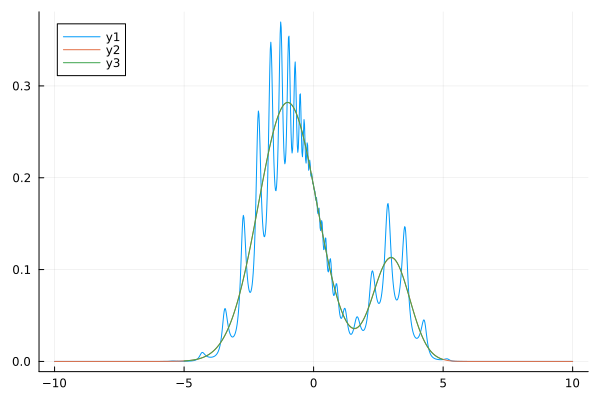

In [13]:
plot()
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val)/pi)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))
#savefig("picture.png")

In [15]:
plot(xlim = [-6,6],
    legend = :topright,
    #ymirror = true, 
    xticks = [5,0,-5],
    yticks = [0.3,0,-0.3],
    xtickfont=font(15), 
    ytickfont=font(15), 
    guidefont=font(25), 
    legendfont=font(20))
plot!(xlabel=latexstring("\\omega"))
plot!(ylabel=latexstring("\\rho"))
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val/pi),label="non-opt",lw=3)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val)/pi),label="opt",lw=3)
plot!(omegas, rho.(omegas), label="exact",lw=1.5,ls=:dash,lc=:black)
savefig("two_peak.svg")

"/home/kosuke/work/Nevanlinna_f/notebooks/two_peak.svg"